In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for b in bboxes:
        cv2.rectangle(draw_img, b[0],b[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
ystart = 400
ystop = 656
scale = 1.1

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

In [5]:

#HOG SUBSAMPLE
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from sklearn.preprocessing import StandardScaler

In [6]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    boxes =[]
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), 
        np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell     

            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features)

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, boxes

/Users/doddarliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LinearSVC from version 0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/doddarliu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


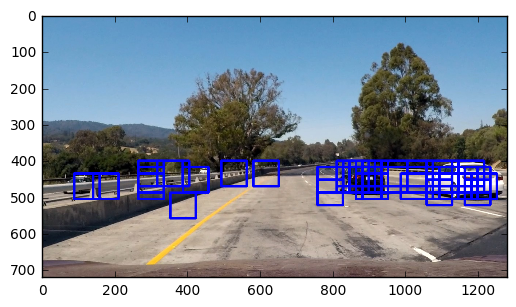

In [7]:
svc = pickle.load( open("saved_svc.p", "rb" ) )
X_scaler =pickle.load( open( "saved_X_scaler.p", "rb" ) )

img = mpimg.imread('test_images/test1.jpg')

out_img, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()

In [8]:
#HEATMAP
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

5 cars found


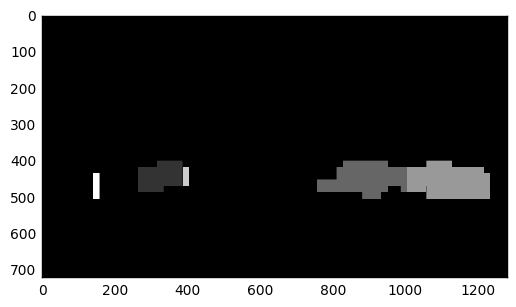

In [9]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,boxes)
heat = apply_threshold(heat,1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

In [10]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
    

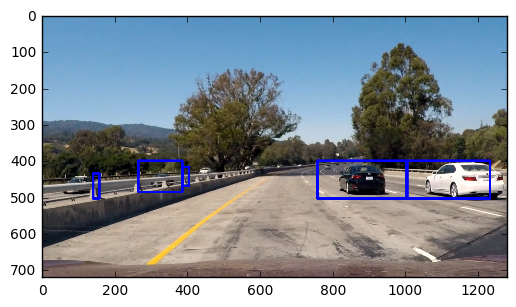

In [11]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.imshow(draw_img)
plt.show()

In [70]:
heat1 = np.zeros_like(img[:,:,0]).astype(np.float)
heat2 = np.zeros_like(img[:,:,0]).astype(np.float)
heat3 = np.zeros_like(img[:,:,0]).astype(np.float)


def process_image(img):
    global heat1 
    global heat2 
    global heat3 
    global heat4 
    ystart = 400
    ystop = 656
    scale = 1.35

    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 8
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16)
    hist_bins = 32
    spatial_feat = True
    hist_feat = True
    hog_feat = True
    svc = pickle.load( open("saved_svc.p", "rb" ) )
    X_scaler =pickle.load( open( "saved_X_scaler.p", "rb" ) )

    out_img, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,boxes)
    heat = 0.7*heat + 0.25*heat1+ 0.05*heat2
    heat = apply_threshold(heat,1.5)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    
    result=draw_labeled_bboxes(img, labels)
    
    heat1=heat
    heat2=heat1

    
    return result

In [71]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [72]:
white_output = 'test.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4




  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:00<00:16,  2.27it/s]

  5%|▌         | 2/39 [00:00<00:15,  2.34it/s]

  8%|▊         | 3/39 [00:01<00:18,  2.00it/s]

 10%|█         | 4/39 [00:02<00:17,  1.98it/s]

 13%|█▎        | 5/39 [00:02<00:15,  2.15it/s]

 15%|█▌        | 6/39 [00:02<00:14,  2.34it/s]

 18%|█▊        | 7/39 [00:03<00:12,  2.51it/s]

 21%|██        | 8/39 [00:03<00:11,  2.62it/s]

 23%|██▎       | 9/39 [00:03<00:10,  2.75it/s]

 26%|██▌       | 10/39 [00:04<00:10,  2.83it/s]

 28%|██▊       | 11/39 [00:04<00:09,  2.85it/s]

 31%|███       | 12/39 [00:04<00:09,  2.88it/s]

 33%|███▎      | 13/39 [00:05<00:08,  2.96it/s]

 36%|███▌      | 14/39 [00:05<00:08,  3.03it/s]

 38%|███▊      | 15/39 [00:05<00:07,  3.08it/s]

 41%|████      | 16/39 [00:06<00:07,  3.06it/s]

 44%|████▎     | 17/39 [00:06<00:07,  3.02it/s]

 46%|████▌     | 18/39 [00:06<00:06,  3.05it/s]

 49%|████▊     | 19/39 [00:07<00:07,  2.62it/s]

 51%|█████▏    | 20/39 [00:07<00:06,

[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

CPU times: user 14.6 s, sys: 1.63 s, total: 16.2 s
Wall time: 16.6 s


In [73]:
white_output = 'white1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white1.mp4
[MoviePy] Writing video white1.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<07:41,  2.73it/s]

  0%|          | 2/1261 [00:00<07:44,  2.71it/s]

  0%|          | 3/1261 [00:01<07:43,  2.72it/s]

  0%|          | 4/1261 [00:01<07:47,  2.69it/s]

  0%|          | 5/1261 [00:01<07:21,  2.85it/s]

  0%|          | 6/1261 [00:02<07:33,  2.77it/s]

  1%|          | 7/1261 [00:02<07:35,  2.76it/s]

  1%|          | 8/1261 [00:02<07:40,  2.72it/s]

  1%|          | 9/1261 [00:03<08:07,  2.57it/s]

  1%|          | 10/1261 [00:03<07:44,  2.69it/s]

  1%|          | 11/1261 [00:04<07:45,  2.68it/s]

  1%|          | 12/1261 [00:04<07:34,  2.75it/s]

  1%|          | 13/1261 [00:04<07:15,  2.87it/s]

  1%|          | 14/1261 [00:05<07:03,  2.94it/s]

  1%|          | 15/1261 [00:05<07:04,  2.93it/s]

  1%|▏         | 16/1261 [00:05<06:59,  2.97it/s]

  1%|▏         | 17/1261 [00:06<07:42,  2.69it/s]

  1%|▏         | 18/1261 [00:06<07:37,  2.72it/s]

  2%|▏         | 19/1261 [00:06<07:25,  2.79it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: white1.mp4 

CPU times: user 8min 3s, sys: 52.9 s, total: 8min 56s
Wall time: 7min 58s


In [ ]:
for i in range(1,7):
    fname = 'test_images/test{}.jpg'.format(i)
    img = mpimg.imread(fname)
    result= process_image(np.copy(img))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(result)
    ax2.set_title('resut', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()